In [3]:
import PIL
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pickle as pkl
from face_alignment import FaceAlignment, LandmarksType
import os

In [4]:
# rootPath = '../../dataForFewShotTalkingHeadModel/train/mp4/'
# personList = os.listdir(rootPath)
# for i, personId in enumerate(personList):
#     videoList = os.listdir(os.path.join(rootPath, personId))
#     for videoId in videoList:
#         videoFiles = os.listdir(os.path.join(rootPath, personId, videoId))
#         for video in videoFiles:
#             print(f'person ID: {i}, path ', os.path.join(rootPath, personId, videoId, video))

In [17]:
def generateVideoList(rootDir):
    """
    Generate a list of video paths, store personId as index
    :param folderPath: root path for all the video files
    :return: a list of video paths
    """
    videoList = []
    
    personList = os.listdir(rootDir)
    for i, personId in enumerate(personList):
        videoListPerPerson = os.listdir(os.path.join(rootDir, personId))
        for videoId in videoListPerPerson:
#             print(videoId)
#             print("*"*8)
            videoFiles = os.listdir(os.path.join(rootDir, personId, videoId))
            for video in videoFiles:
                print(video)
                if(os.path.splitext(video)[1] == '.mp4'):
                    videoList.append({"personId":i, "videoPath":os.path.join(rootDir, personId, videoId, video)})
    return videoList


def selectKRandomFramesForSpecificVideo(K, filePath):
    """
    Random select K frames from all the frame of the video
    :param K: Number of frames that we want to withdraw
    :param filePath: video path
    :param randomSeed: if we set the randomSeed, each epoch we will get the same frame from the same video, if the randomSeed is none, then different frames.
    :return: K random selected frames
    """
    cap = cv2.VideoCapture(filePath)
    total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    randomIndex = np.random.choice(total, K)

    selectedFrames = []

    for index in randomIndex:
        # After this setting, we could get index'th frame by cap.read each time.
        cap.set(cv2.CAP_PROP_POS_FRAMES, index)
        ret, frame = cap.read()
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        selectedFrames.append(frame)

    cap.release()
    return selectedFrames


def generateLandmarksForSpecificVideo(frames, fa):
    """
    Generate landmark frames for input frames
    :param frames:
    :param fa: face-alignment.FaceAlignment object
    :return: a list of landmark frames, [K, H, W, 3]
    """

    def generateLandmarkForSpecificFrame(frame, landmark):
        """
        Get the landmark frame by drawing the figure, then we store the figure in a [H, W, 3] data.
        :param frame:
        :param landmark: landmark generated by fa, landmark is [x, y] format.
        :return:
        """
        fig = plt.figure(figsize=(frame.shape[1] / 100, frame.shape[0] / 100), dpi=100)
        ax = fig.add_subplot(1, 1, 1)
        ax.imshow(np.ones(frame.shape))
        plt.subplots_adjust(left=0, right=1, top=1, bottom=0)

        # Head
        ax.plot(landmark[0:17, 0], landmark[0:17, 1], linestyle='-', color='green', lw=2)
        # Eyebrows
        ax.plot(landmark[17:22, 0], landmark[17:22, 1], linestyle='-', color='orange', lw=2)
        ax.plot(landmark[22:27, 0], landmark[22:27, 1], linestyle='-', color='orange', lw=2)
        # Nose
        ax.plot(landmark[27:31, 0], landmark[27:31, 1], linestyle='-', color='blue', lw=2)
        ax.plot(landmark[31:36, 0], landmark[31:36, 1], linestyle='-', color='blue', lw=2)
        # Eyes
        ax.plot(landmark[36:42, 0], landmark[36:42, 1], linestyle='-', color='red', lw=2)
        ax.plot(landmark[42:48, 0], landmark[42:48, 1], linestyle='-', color='red', lw=2)
        # Mouth
        ax.plot(landmark[48:60, 0], landmark[48:60, 1], linestyle='-', color='purple', lw=2)

        fig.canvas.draw()
        
        data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        print(data.shape)

        data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        
        plt.close(fig)


        return data

    landmarkFrames = []
    for frame in frames:
        # landmark -> [x, y]
        landmark = fa.get_landmarks(frame)[0]
        landmarkFrame = generateLandmarkForSpecificFrame(frame, landmark)
        landmarkFrames.append(landmarkFrame)

    return landmarkFrames


def generateKSelectedFramesAndLandmarksForSpecificVideo(K, video, outputDir, fa):
    """
    Generate random frame list and landmark frame list, which are both [K, H. W. 3].
    :param K: Number of frames
    :param videoPath:
    :param fa: face-.FaceAlignment object
    :param randomSeed: random seed for random frames
    :return: two list
    """
    
    personId = video["personId"]
    videoPath = video["videoPath"]
    
    if not os.path.isdir(outputDir):
        os.makedirs(outputDir)

    outputPath = os.path.join(outputDir, f'personId_{personId}_' + os.path.basename(os.path.dirname(videoPath)) + '.vid')
    if os.path.exists(outputPath):
        data = pkl.load(open(outputPath, 'rb'))
        return data

    selectedFrames = selectKRandomFramesForSpecificVideo(K, videoPath)
    landmarkFrames = generateLandmarksForSpecificVideo(selectedFrames, fa)

    data = []

    for selectedFrame, landmarkFrame in zip(selectedFrames, landmarkFrames):
        data.append({"personId": personId,
                     "frame": selectedFrame,
                     "landmarks": landmarkFrame})

    pkl.dump(data, open(outputPath, 'wb'))

    return data

In [18]:
K = 8
rootDir = '../../dataForFewShotTalkingHeadModel/train/mp4/'
outputDir = '../../dataForFewShotTalkingHeadModel/train/output/'
device = 'cpu'
videoList = generateVideoList(rootDir)
fa = FaceAlignment(LandmarksType._2D, device=device)

00001.mp4
00002.mp4
00003.mp4
00004.mp4
00005.mp4
00006.mp4
00007.mp4
00008.mp4
00009.mp4
00010.mp4
00011.mp4
00012.mp4
00013.mp4
00014.mp4
00015.mp4
00016.mp4
00017.mp4
00018.mp4
00019.mp4
00020.mp4
00021.mp4
00022.mp4
00023.mp4
00024.mp4
00025.mp4
00026.mp4
00096.mp4
00097.mp4
00098.mp4
00099.mp4
00100.mp4
00101.mp4
00102.mp4
00103.mp4
00104.mp4
00027.mp4
00028.mp4
00105.mp4
00106.mp4
00107.mp4
00108.mp4
00109.mp4
00110.mp4
00111.mp4
00112.mp4
00113.mp4
00114.mp4
00115.mp4
00116.mp4
00117.mp4
00118.mp4
00119.mp4
00120.mp4
00121.mp4
00122.mp4
00123.mp4
00124.mp4
00125.mp4
00126.mp4
00127.mp4
00128.mp4
00129.mp4
00131.mp4
00132.mp4
00133.mp4
00134.mp4
00135.mp4
00136.mp4
00137.mp4
00138.mp4
00029.mp4
00030.mp4
00031.mp4
00166.mp4
00167.mp4
00168.mp4
00169.mp4
00170.mp4
00171.mp4
00172.mp4
00173.mp4
00174.mp4
00175.mp4
00176.mp4
00177.mp4
00178.mp4
00179.mp4
00180.mp4
00181.mp4
00182.mp4
00183.mp4
00184.mp4
00185.mp4
00186.mp4
00187.mp4
00188.mp4
00189.mp4
00190.mp4
00139.mp4
00140.mp4


00040.mp4
00041.mp4
00042.mp4
00043.mp4
00044.mp4
00045.mp4
00046.mp4
00047.mp4
00048.mp4
00049.mp4
00050.mp4
00051.mp4
00052.mp4
00053.mp4
00054.mp4
00055.mp4
00056.mp4
00057.mp4
00058.mp4
00059.mp4
00060.mp4
00061.mp4
00128.mp4
00129.mp4
00130.mp4
00131.mp4
00132.mp4
00133.mp4
00134.mp4
00135.mp4
00136.mp4
00137.mp4
00138.mp4
00139.mp4
00140.mp4
00141.mp4
00142.mp4
00143.mp4
00144.mp4
00145.mp4
00146.mp4
00147.mp4
00062.mp4
00063.mp4
00064.mp4
00065.mp4
00066.mp4
00067.mp4
00068.mp4
00069.mp4
00070.mp4
00071.mp4
00072.mp4
00073.mp4
00074.mp4
00075.mp4
00076.mp4
00077.mp4
00078.mp4
00079.mp4
00080.mp4
00081.mp4
00082.mp4
00083.mp4
00084.mp4
00085.mp4
00086.mp4
00087.mp4
00088.mp4
00089.mp4
00090.mp4
00091.mp4
00092.mp4
00093.mp4
00094.mp4
00095.mp4
00096.mp4
00097.mp4
00098.mp4
00099.mp4
00100.mp4
00101.mp4
00102.mp4
00103.mp4
00104.mp4
00148.mp4
00149.mp4
00105.mp4
00106.mp4
00107.mp4
00108.mp4
00109.mp4
00110.mp4
00111.mp4
00112.mp4
00113.mp4
00114.mp4
00115.mp4
00116.mp4
00150.mp4


In [19]:
videoList

[{'personId': 0,
  'videoPath': '../../dataForFewShotTalkingHeadModel/train/mp4/id00017\\01dfn2spqyE\\00001.mp4'},
 {'personId': 0,
  'videoPath': '../../dataForFewShotTalkingHeadModel/train/mp4/id00017\\5MkXgwdrmJw\\00002.mp4'},
 {'personId': 0,
  'videoPath': '../../dataForFewShotTalkingHeadModel/train/mp4/id00017\\7t6lfzvVaTM\\00003.mp4'},
 {'personId': 0,
  'videoPath': '../../dataForFewShotTalkingHeadModel/train/mp4/id00017\\7t6lfzvVaTM\\00004.mp4'},
 {'personId': 0,
  'videoPath': '../../dataForFewShotTalkingHeadModel/train/mp4/id00017\\7t6lfzvVaTM\\00005.mp4'},
 {'personId': 0,
  'videoPath': '../../dataForFewShotTalkingHeadModel/train/mp4/id00017\\7t6lfzvVaTM\\00006.mp4'},
 {'personId': 0,
  'videoPath': '../../dataForFewShotTalkingHeadModel/train/mp4/id00017\\7t6lfzvVaTM\\00007.mp4'},
 {'personId': 0,
  'videoPath': '../../dataForFewShotTalkingHeadModel/train/mp4/id00017\\7t6lfzvVaTM\\00008.mp4'},
 {'personId': 0,
  'videoPath': '../../dataForFewShotTalkingHeadModel/train/mp4/

AttributeError: 'bytes' object has no attribute 'shape'

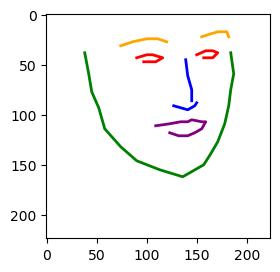

In [12]:

data = generateKSelectedFramesAndLandmarksForSpecificVideo(K+1, videoList[21], outputDir, fa)

In [ ]:

for i in range(8):
    f, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(data[i]['frame'])
    ax2.imshow(data[i]['landmarks'])

In [6]:
data[0]["personId"]

0